<a href="https://colab.research.google.com/github/pruhnav/LoadForecasting/blob/main/Price_forecast_XGBoost%2C_BiLSTM%2C_LSTM%2C_GRU%2C_Transformer%2C_CNN%2C_Hybrid_48h_6t.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy Price Prediction with XGBoost & BiLSTM

# Task for reza
- Make the progam to forecast 24 hours of prices at once.
- Change the input from t = 24, 24*3, 24*5, 24*7, 24*9, 24*11.
- Input for others 24*7, Output t = 24.
- See link: https://ieeexplore-ieee-org.ezaccess.libraries.psu.edu/stamp/stamp.jsp?tp=&arnumber=10214317
- Create Fig. 10 for MAE (Mean Absulute Error) and RMSE (Root Mean Squared Error) for Test data set (Proposed Hybrid Model).
- Two cases comparison (Actual vs Predcited): Best and Worst week.
- Whole year (2023) Actual vs Predicted and (Residual = Actual - Predicted)


In [48]:
from google.colab import files

# Open file upload dialog
#uploaded = files.upload()

In [49]:
import pandas as pd

# Load the uploaded Excel file
df = pd.read_excel('day_ahead_energy_prices.xlsx')

# Display the first few rows of the DataFrame
print(df.head())


                 Date  Price
0 2016-01-01 00:00:00  30.19
1 2016-01-01 01:00:00  25.35
2 2016-01-01 02:00:00  21.12
3 2016-01-01 03:00:00  21.07
4 2016-01-01 04:00:00  22.44


In [50]:
df.head()

,Date,Price
0,2016-01-01 00:00:00,30.19
1,2016-01-01 01:00:00,25.35
2,2016-01-01 02:00:00,21.12
3,2016-01-01 03:00:00,21.07
4,2016-01-01 04:00:00,22.44


In [51]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [52]:
# Assuming `df` is your DataFrame containing 'Date' and 'Price'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [53]:


# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create data structure for BiLSTM
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def prepare_data(data, look_back=48, look_ahead=6):
  X, y = [], []
  for i in range(len(data) - look_back - look_ahead + 1):
    X.append(data[i:(i + look_back)])
    y.append(data[(i + look_back):(i + look_back + look_ahead)])
  return np.array(X), np.array(y)


#X, y = create_dataset(scaled_data)
X, y = prepare_data(scaled_data)
X.shape,y.shape

((70075, 48, 1), (70075, 6, 1))

In [54]:
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for BiLSTM input

# Split into training and testing sets based on year
train_df = df[df.index.year <= 2022]
test_df = df[df.index.year == 2023]
train_scaled = scaler.transform(train_df['Price'].values.reshape(-1, 1))
test_scaled = scaler.transform(test_df['Price'].values.reshape(-1, 1))

X_train, y_train = prepare_data(train_scaled)
X_test, y_test = prepare_data(test_scaled)


In [55]:

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [56]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(61315, 48, 1) (61315, 6, 1)
(8707, 48, 1) (8707, 6, 1)


In [57]:
EPOCH = 3 # change here

In [58]:

# Build BiLSTM Model
def build_bilstm_model(input_shape, lstm_units=64, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(lstm_units, return_sequences=False))(inputs)

    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(6)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

bilstm_model = build_bilstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

In [59]:
# prompt: create xgboost model function

def create_xgboost_model(X_train, y_train):
  """Creates and trains an XGBoost model.

  Args:
    X_train: Training input data.
    y_train: Training target data.

  Returns:
    Trained XGBoost model.
  """
  xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
  xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
  return xgb_model


In [60]:
# Train BiLSTM

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCH,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/3
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 8.8231e-04 - val_loss: 5.3759e-04
Epoch 2/3
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 4.3210e-04 - val_loss: 8.4869e-04
Epoch 3/3
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 5.0482e-04 - val_loss: 4.6033e-04


In [61]:
# prompt: see layers of bilstm_model

bilstm_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,236 (598.58 KB)

 Trainable params: 51,078 (199.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 102,158 (399.06 KB)

In [62]:
# prompt: apply the bilstm model and give the mse, rmse, mae, smape, and r^2 score

# Predict using BiLSTM
y_pred_bilstm = bilstm_model.predict(X_test)

# Inverse transform the predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_bilstm_inv = scaler.inverse_transform(y_pred_bilstm.reshape(-1, 1))

# Calculate evaluation metrics
mse_bilstm = mean_squared_error(y_test_inv, y_pred_bilstm_inv)
rmse_bilstm = np.sqrt(mse_bilstm)
mae_bilstm = mean_absolute_error(y_test_inv, y_pred_bilstm_inv)

# SMAPE calculation
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape_bilstm = smape(y_test_inv, y_pred_bilstm_inv)

r2_bilstm = r2_score(y_test_inv, y_pred_bilstm_inv)

print(f"BiLSTM - MSE: {mse_bilstm:.4f}")
print(f"BiLSTM - RMSE: {rmse_bilstm:.4f}")
print(f"BiLSTM - MAE: {mae_bilstm:.4f}")
print(f"BiLSTM - SMAPE: {smape_bilstm:.4f}")
print(f"BiLSTM - R^2 Score: {r2_bilstm:.4f}")


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
BiLSTM - MSE: 126.4824
BiLSTM - RMSE: 11.2464
BiLSTM - MAE: 5.4026
BiLSTM - SMAPE: 12.9465
BiLSTM - R^2 Score: 0.8178


In [63]:
# prompt: apply the xgboost model and give the mse, rmse, mae, smape, and r^2 score

# Train XGBoost
xgb_model = create_xgboost_model(X_train, y_train)

# Predict using XGBoost
y_pred_xgb = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))


# Inverse transform the predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_xgb_inv = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test_inv, y_pred_xgb_inv)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test_inv, y_pred_xgb_inv)
smape_xgb = smape(y_test_inv, y_pred_xgb_inv)
r2_xgb = r2_score(y_test_inv, y_pred_xgb_inv)

print(f"XGBoost - MSE: {mse_xgb:.4f}")
print(f"XGBoost - RMSE: {rmse_xgb:.4f}")
print(f"XGBoost - MAE: {mae_xgb:.4f}")
print(f"XGBoost - SMAPE: {smape_xgb:.4f}")
print(f"XGBoost - R^2 Score: {r2_xgb:.4f}")


XGBoost - MSE: 116.3108
XGBoost - RMSE: 10.7847
XGBoost - MAE: 4.5118
XGBoost - SMAPE: 10.3185
XGBoost - R^2 Score: 0.8325


In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(48, 1)))  # assuming univariate input
lstm_model.add(Dense(6))  # 6-hour forecast
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,286 (67.52 KB)

 Trainable params: 17,286 (67.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 8.6202e-04 - val_loss: 0.0043
Epoch 2/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.0406e-04 - val_loss: 0.0037
Epoch 3/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.3308e-04 - val_loss: 0.0027
Epoch 4/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.5274e-04 - val_loss: 0.0025
Epoch 5/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.2251e-04 - val_loss: 0.0023
Epoch 6/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.1060e-04 - val_loss: 0.0021
Epoch 7/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.9803e-04 - val_loss: 0.0019
Epoch 8/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.9553e-04 - val_loss: 0.0020
Epoch 9/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.0155e-04 - val_loss: 0.0019
Epoch 10/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.8202e-04 - val_loss: 0.0019
Epoch 11/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.844

In [65]:
from tensorflow.keras.layers import GRU

gru_model = Sequential()
gru_model.add(GRU(64, activation='relu', input_shape=(48, 1)))
gru_model.add(Dense(6))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.summary()

gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,254 (51.77 KB)

 Trainable params: 13,254 (51.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 9.1575e-04 - val_loss: 0.0034
Epoch 2/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 3.4343e-04 - val_loss: 0.0030
Epoch 3/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.2513e-04 - val_loss: 0.0029
Epoch 4/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.1714e-04 - val_loss: 0.0029
Epoch 5/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.9820e-04 - val_loss: 0.0033
Epoch 6/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.7464e-04 - val_loss: 0.0032
Epoch 7/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.5563e-04 - val_loss: 0.0032
Epoch 8/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.4267e-04 - val_loss: 0.0029
Epoch 9/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.3602e-04 - val_loss: 0.0022
Epoch 10/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.2869e-04 - val_loss: 0.0023
Epoch 11/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.258

In [66]:
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model

inputs = Input(shape=(48, 1))
x = Dense(64)(inputs)
x = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(6)(x)

transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.summary()

transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 48, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 48, 64)    │        128 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 64)    │     16,640 │ dense_8[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 48, 64)    │        128 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 48, 64)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dropout_3[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 6)         │        390 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,286 (67.52 KB)

 Trainable params: 17,286 (67.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 2/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 6.5703e-04 - val_loss: 0.0050
Epoch 3/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6.1584e-04 - val_loss: 0.0049
Epoch 4/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.8534e-04 - val_loss: 0.0051
Epoch 5/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.9382e-04 - val_loss: 0.0049
Epoch 6/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.8849e-04 - val_loss: 0.0052
Epoch 7/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.7804e-04 - val_loss: 0.0050
Epoch 8/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.6767e-04 - val_loss: 0.0049
Epoch 9/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.8378e-04 - val_loss: 0.0051
Epoch 10/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.7506e-04 - val_loss: 0.0050
Epoch 11/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.5819e-04 - 

In [67]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(48, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(6))
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.summary()

cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 46, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        94,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,918 (370.77 KB)

 Trainable params: 94,918 (370.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.9725e-04 - val_loss: 0.0017
Epoch 2/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.8297e-04 - val_loss: 0.0016
Epoch 3/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.6921e-04 - val_loss: 0.0015
Epoch 4/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.5658e-04 - val_loss: 0.0015
Epoch 5/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.5509e-04 - val_loss: 0.0014
Epoch 6/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4965e-04 - val_loss: 0.0017
Epoch 7/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4999e-04 - val_loss: 0.0015
Epoch 8/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.4799e-04 - val_loss: 0.0015
Epoch 9/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.4508e-04 - val_loss: 0.0015
Epoch 10/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4283e-04 - val_loss: 0.0014
Epoch 11/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.3758e-04 - va

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

def evaluate_model(model, X_test, y_test, scaler=None, model_name="Model"):
    y_pred = model.predict(X_test)

    y_test = np.squeeze(y_test)
    y_pred = np.squeeze(y_pred)

    # Inverse scale if scaler is given
    if scaler:
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    smape_score = smape(y_test, y_pred)

    print(f"{model_name} - MSE: {mse:.4f}")
    print(f"{model_name} - RMSE: {rmse:.4f}")
    print(f"{model_name} - MAE: {mae:.4f}")
    print(f"{model_name} - SMAPE: {smape_score:.2f}%")
    print(f"{model_name} - R^2 Score: {r2:.4f}")


In [73]:
evaluate_model(lstm_model, X_test, y_test, scaler=scaler, model_name="LSTM")
evaluate_model(gru_model, X_test, y_test, scaler=scaler, model_name="GRU")
evaluate_model(transformer_model, X_test, y_test, scaler=scaler, model_name="Transformer")
evaluate_model(cnn_model, X_test, y_test, scaler=scaler, model_name="CNN")


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM - MSE: 126.9471
LSTM - RMSE: 11.2671
LSTM - MAE: 5.2103
LSTM - SMAPE: 12.44%
LSTM - R^2 Score: 0.8171
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
GRU - MSE: 167.2894
GRU - RMSE: 12.9340
GRU - MAE: 5.7863
GRU - SMAPE: 13.53%
GRU - R^2 Score: 0.7590
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Transformer - MSE: 408.0716
Transformer - RMSE: 20.2008
Transformer - MAE: 10.1956
Transformer - SMAPE: 24.06%
Transformer - R^2 Score: 0.4122
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CNN - MSE: 150.0839
CNN - RMSE: 12.2509
CNN - MAE: 5.2088
CNN - SMAPE: 12.22%
CNN - R^2 Score: 0.7838


In [75]:
import pandas as pd

results = []

results.append({
    "Model": "XGBoost",
    "MSE": 116.31,
    "RMSE": 10.78,
    "MAE": 4.51,
    "SMAPE": 10.32,
    "R2": 0.8325
})

results.append({
    "Model": "LSTM",
    "MSE": 126.95,
    "RMSE": 11.27,
    "MAE": 5.21,
    "SMAPE": 12.44,
    "R2": 0.8171
})

results.append({
    "Model": "GRU",
    "MSE": 167.29,
    "RMSE": 12.93,
    "MAE": 5.79,
    "SMAPE": 13.53,
    "R2": 0.7590
})

results.append({
    "Model": "Transformer",
    "MSE": 408.07,
    "RMSE": 20.20,
    "MAE": 10.20,
    "SMAPE": 24.06,
    "R2": 0.4122
})

results.append({
    "Model": "CNN",
    "MSE": 150.08,
    "RMSE": 12.25,
    "MAE": 5.21,
    "SMAPE": 12.22,
    "R2": 0.7838
})

results.append({
    "Model": "Hybrid",
    "MSE": 123.06,
    "RMSE": 11.09,
    "MAE": 5.03,
    "SMAPE": 11.92,
    "R2": 0.8227
})

df_results = pd.DataFrame(results)
print(df_results)


         Model     MSE   RMSE    MAE  SMAPE      R2
0      XGBoost  116.31  10.78   4.51  10.32  0.8325
1         LSTM  126.95  11.27   5.21  12.44  0.8171
2          GRU  167.29  12.93   5.79  13.53  0.7590
3  Transformer  408.07  20.20  10.20  24.06  0.4122
4          CNN  150.08  12.25   5.21  12.22  0.7838
5       Hybrid  123.06  11.09   5.03  11.92  0.8227


### Task - HYBRID MODEL
input 24, 48, 72, 96

change the feature to 30, 60, 90, 120

In [ ]:
# Extract Features from BiLSTM
intermediate_layer_model = Model(inputs=bilstm_model.input, outputs=bilstm_model.layers[-2].output)
bilstm_features_train = intermediate_layer_model.predict(X_train)
bilstm_features_test = intermediate_layer_model.predict(X_test)

In [ ]:
bilstm_features_train.shape,bilstm_features_test.shape

In [ ]:
# sMAPE Calculation
def calculate_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # handle the case where both prediction and actual are zero
    return 100 * np.mean(diff)



# Modified MAPE Calculation (exclude zero values in actual prices)
def calculate_mape(y_true, y_pred):
    non_zero_mask = y_true != 0  # Exclude zero actual values
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

In [ ]:
evaluation_data = pd.DataFrame(columns=['Model', 'MAPE', 'RMSE', 'MAE', 'R2'])
def evaluation_metrics(y_test_original, y_pred_original, model_name="No Model"):
  mae = mean_absolute_error(y_test_original, y_pred_original)
  rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
  mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
  r2 = r2_score(y_test_original, y_pred_original)


  #print(f"Mean Absolute Percentage Error (MAPE): {mape*100}")
  #print(f"RMSE: {rmse}")
  #print(f"Mean Absolute Error (MAE): {mae}")
  #print(f"R-squared (R2): {r2}")
  # Create a new row as a dictionary
  new_row = {'Model': model_name, 'MAPE': mape*100 , 'RMSE': rmse , 'MAE': mae , 'R2': r2 }
  global evaluation_data;
  # Add the new row using the loc indexer
  evaluation_data.loc[model_name] = new_row
  #print(evaluation_data)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
# Train XGBoost with BiLSTM Features
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
y_train_reshaped = y_train.reshape(y_train.shape[0], -1)  # Reshape to (num_samples, 24)
xgb_model.fit(bilstm_features_train, y_train_reshaped, verbose=True)



# Save Actual vs Predicted Prices in Excel
#results_df = pd.DataFrame({
 #   'Date': test_df.index[-len(xgb_predictions):],
  #  'Actual Price': test_actual.flatten(),
   # 'Predicted Price': xgb_predictions_rescaled.flatten()
#})
#results_df.to_excel('actual_vs_predicted.xlsx', index=False)
#print("Actual vs Predicted saved to 'actual_vs_predicted.xlsx'.")




In [ ]:

# Make Predictions with XGBoost
xgb_predictions = xgb_model.predict(bilstm_features_test)
xgb_predictions_rescaled = scaler.inverse_transform(xgb_predictions.reshape(-1, 6))

# Rescale Test Data
test_actual = scaler.inverse_transform(y_test.reshape(-1, 6))

In [ ]:
evaluation_metrics(test_actual, xgb_predictions_rescaled, f"XGBoost_look_back_48_hour")
evaluation_data

In [ ]:
test_actual

In [ ]:
xgb_predictions_rescaled

In [ ]:
# prompt: find the difference between test_actual and xgb_predictions_rescaled where  every item comparison difference is more than 10

# Find differences greater than 10
differences = np.abs(test_actual - xgb_predictions_rescaled)
indices = np.where(differences > 10)

# Print the indices and values where the difference is greater than 10
print("Indices where the difference is greater than 10:")
print(indices)

print("\nDifferences greater than 10:")
print(differences[indices])

# Access the corresponding values from test_actual and xgb_predictions_rescaled
print("\nValues from test_actual:")
print(test_actual[indices])

print("\nValues from xgb_predictions_rescaled:")
xgb_predictions_rescaled[indices]


In [74]:
# Evaluation Metrics
mse = mean_squared_error(test_actual, xgb_predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_actual, xgb_predictions_rescaled)
r2 = r2_score(test_actual, xgb_predictions_rescaled)

smape = calculate_smape(test_actual, xgb_predictions_rescaled)

mape = mean_absolute_percentage_error(test_actual, xgb_predictions_rescaled)

print(f"Hybrid Model Evaluation:\nMAE: {mae}, RMSE: {rmse}, sMAPE: {smape}%, MAPE: {mape}, R^2: {r2}, MSE: {mse}")


Hybrid Model Evaluation:
MAE: 5.029620179606803, RMSE: 11.093432866482479, sMAPE: 11.915368525492141%, MAPE: 11089626275927.523, R^2: 0.8227330119052612, MSE: 123.06425276315366


In [ ]:
# prompt: draw a line graph based test_actual and xgb_predictions_rescaled data every 24 data

import matplotlib.pyplot as plt

# Assuming xgb_predictions_rescaled and test_actual are already defined

# Plotting every 24th data point
plt.figure(figsize=(12, 6))
plt.plot(test_actual.flatten()[10000:20000:24], label='Actual')
plt.plot(xgb_predictions_rescaled.flatten()[10000:20000:24], label='Predicted')
plt.xlabel('Time Step (every 24)')
plt.ylabel('Energy Price')
plt.title('Actual vs Predicted Energy Prices (every 24 data points)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Visualization
SHOW_TEST_VALUES = 400

plt.figure(figsize=(15, 5))
plt.plot(test_df.index[-SHOW_TEST_VALUES:], test_actual[-SHOW_TEST_VALUES:], label='Actual Price')
plt.plot(test_df.index[-SHOW_TEST_VALUES:], xgb_predictions_rescaled[-SHOW_TEST_VALUES:], label='Predicted Price')
plt.title('Energy Price Prediction using Hybrid XGBoost-BiLSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))#'%Y-%m-%d %H:%M
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig("Energy Price Prediction(proposed).pdf", bbox_inches='tight')
plt.show()

In [ ]:
print("Extracted Features (Training):")
print(bilstm_features_train)

In [ ]:
training_features_df = pd.DataFrame(bilstm_features_train)
# training_features_df.to_excel('bilstm_features_train.xlsx', index=False) %%


To apply SHAP (SHapley Additive exPlanations) to a hybrid model combining BiLSTM and XGBoost, you need to follow a structured approach depending on how you integrate both models. Typically, this hybrid approach consists of two stages:

Feature Extraction using BiLSTM: A BiLSTM (Bidirectional Long Short-Term Memory) network processes sequential data and extracts meaningful features.
Prediction using XGBoost: The extracted features are then passed to an XGBoost model for final predictions.
## Applying SHAP to this Hybrid Model
Since SHAP explanations depend on the model type, you need to determine whether to explain the BiLSTM model, the XGBoost model, or both

Exception ignored in: <function _xla_gc_callback at 0x7c84f5da3740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


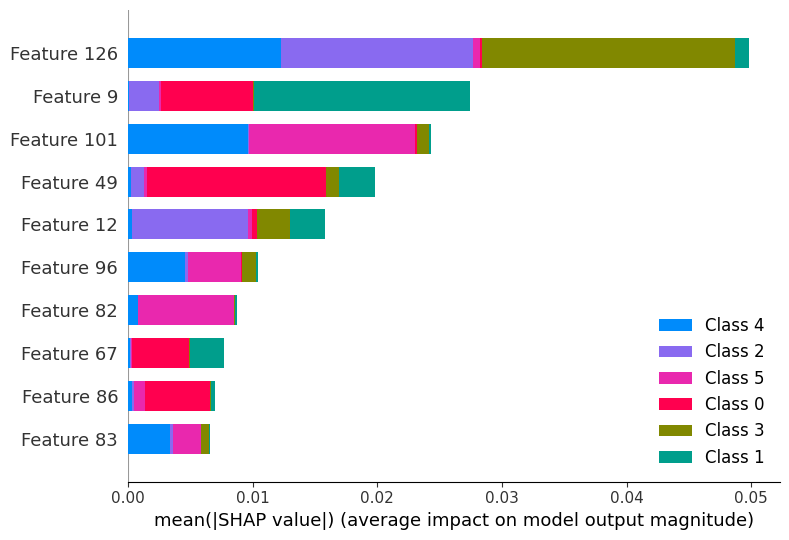

In [44]:
import shap
# Explain XGBoost predictions using SHAP values
explainer = shap.Explainer(xgb_model)
shap_values = explainer(bilstm_features_test)

# Visualize SHAP values
shap.summary_plot(shap_values, bilstm_features_test, plot_type="bar",max_display=10,show=False)
plt.savefig("shap_summary_plot_bilstm_features_bar_graph.pdf", bbox_inches='tight')
plt.show()

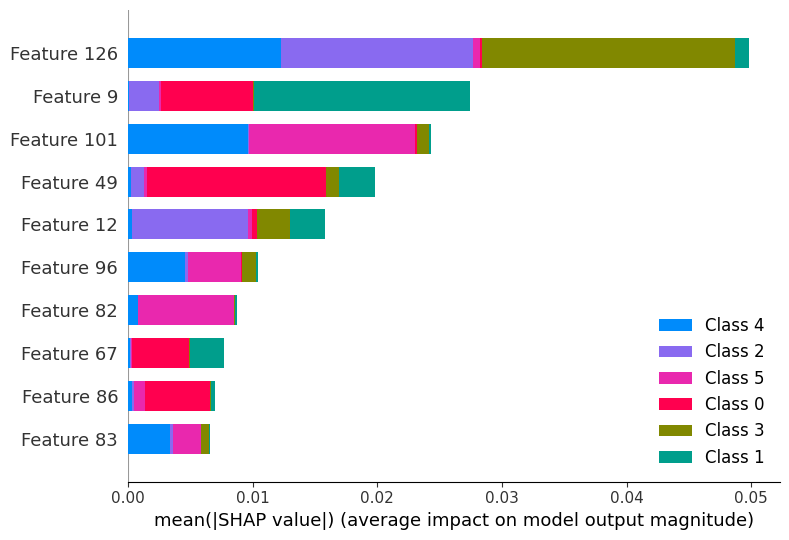

In [45]:

shap.summary_plot(shap_values, bilstm_features_test,max_display=10,show=False)
plt.savefig("shap_summary_plot_bilstm_features.pdf", bbox_inches='tight')
plt.show()

In [46]:
X_train_temp = X_train.reshape(X_train.shape[0],-1)
X_test_temp = X_test.reshape(X_test.shape[0],-1)
num_features = X_train_temp.shape[1]

# Generate column names (Modify this based on actual feature names)
feature_names = [f"t-{60-i}" for i in range(num_features)]  # Default names
X_train_df = pd.DataFrame(X_train_temp, columns=feature_names)
X_test_df = pd.DataFrame(X_test_temp, columns=feature_names)

In [47]:
NUM_ROWS = 500
explainer_bilstm = shap.Explainer(bilstm_model, X_train_df[:NUM_ROWS])  # Sample subset for efficiency
shap_values_bilstm = explainer_bilstm(X_test_df[:NUM_ROWS])




PermutationExplainer explainer:  11%|█         | 54/500 [00:30<05:24,  1.37it/s]


KeyboardInterrupt: 

In [ ]:
#shap.summary_plot(shap_values_bilstm, X_test_df, plot_type="bar",max_display=10,show=False)

#plt.savefig("shap_summary_plot_bilstm_average_impact.pdf", bbox_inches='tight')
#plt.show()


In [ ]:
# Visualize the SHAP values for BiLSTM

shap.summary_plot(shap_values_bilstm, X_test_df[:NUM_ROWS], max_display=10,show=False)


plt.savefig("shap_summary_plot_bilstm_impact_on_model_output.pdf", bbox_inches='tight')
plt.show()

#t-1, t-2 .....

In [ ]:
shap.plots.waterfall(shap_values_bilstm[1],show=False)


plt.savefig("shap_summary_plot_bilstm_waterfall.pdf", bbox_inches='tight')
plt.show()


In [ ]:
shap.plots.bar(shap_values_bilstm,show=False)
plt.savefig("shap_summary_plot_bilstm_mean_shap_value.pdf", bbox_inches='tight')
plt.show()

In [ ]:

explainer_bilstm = shap.Explainer(bilstm_model, X_train_df[:10])
shap_values_bilstm = explainer_bilstm(X_test_df[:10])

# Instead of using explainer_bilstm.model.predict, use your original model:
expected_value = bilstm_model.predict(X_train_df[:10]).mean()

shap.decision_plot(expected_value, shap_values_bilstm[1].values, X_test_df.columns,show=False)
plt.savefig("shap_summary_plot_bilstm_model_output.pdf", bbox_inches='tight')
plt.show()

In [ ]:
shap.plots.beeswarm(shap_values_bilstm)